# IsoModulator example

## Preliminary setup

### Modules

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../../PaperI/'))

from EmpiricalArchive.IsoModulator.Simulation_functions import *
from itertools import product
import seaborn as sns

from EmpiricalArchive.Extraction.pre_processing import cluster_df_list
from EmpiricalArchive.Extraction.Classfile import star_cluster

from EmpiricalArchive.My_tools import my_utility
from EmpiricalArchive.My_tools.plotting_essentials import CMD_density_design

from scipy.integrate import simps

## set paths

In [2]:
output_path = my_utility.set_output_path(
    main_path="/Users/alena/Library/CloudStorage/OneDrive-Personal/Work/PhD/Projects/Isochrone_Archive/Coding_logs/")
mastertable_path = "/Users/alena/PycharmProjects/PaperI/EmpiricalArchive/data/Isochrones/Mastertable_Archive.csv"
results_path = "/Users/alena/PycharmProjects/PaperI/EmpiricalArchive/data/Isochrones/Simulations/"

HP_file = "/Users/alena/PycharmProjects/PaperI/EmpiricalArchive/data/Hyperparameters/Simulations_1.csv"
my_utility.setup_HP(HP_file)

### Plotting kwargs

In [3]:
kwargs = dict(grid=None, HP_file=HP_file)
# sns.set_style("darkgrid")
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["font.size"] = 18

## 1. Define parameter uncertainty values

In [4]:
uncertainties = [0.1, 0.3, 0.5, 0.4]

# define clusters
cluster = "Melotte_22"

# load and filter isochrone table and cluster_data_table
mastertable = pd.read_csv(mastertable_path)
filtered_df = mastertable[mastertable["Cluster"].isin([cluster])]
Archive_df = pd.concat(cluster_df_list, axis=0)

## 2. Initialize class object

In [5]:
CMD1 = simulated_CMD(cluster_name=cluster, isochrone_df=filtered_df, cluster_data_df=Archive_df)

# set CMD type
CMD1.set_CMD_type(1)

## 3. Add uncertainties and plot the result

/Users/alena/PycharmProjects/PaperI/EmpiricalArchive/IsoModulator/Simulation_functions.py:195: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/var/folders/z6/y4rdkpdx3vlbwtmngx04x_1w0000gp/T/ipykernel_18950/3922852537.py:3: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



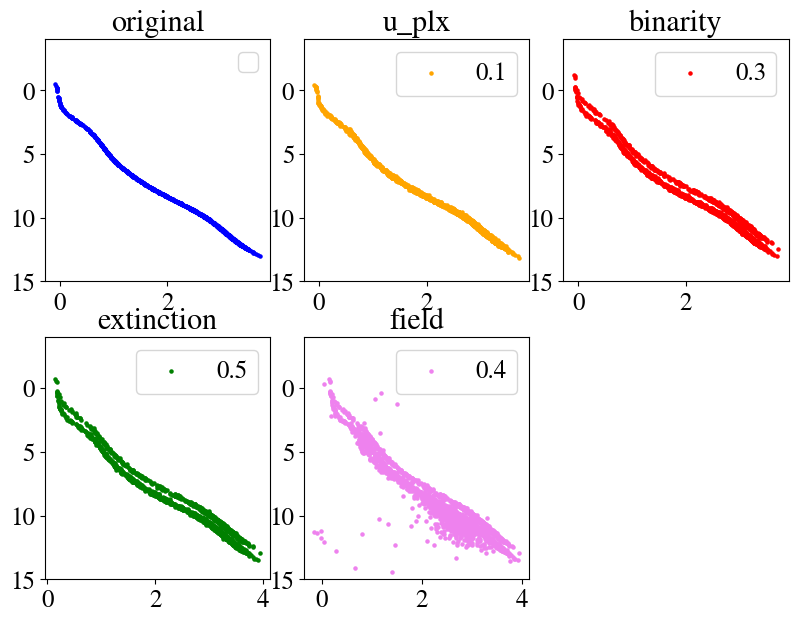

In [6]:
cmd_data = CMD1.simulate(uncertainties)
fig, axes = CMD1.plot_verification(uncertainties)
fig.show()

## 4. Calculate the new isochrone

In [7]:
OC = star_cluster(name=cluster, catalog=cmd_data, dataset_id=2)
OC.create_CMD_quick_n_dirty(CMD_params=["Gmag", "BP-RP"], no_errors=True)

# Do some initial HP tuning if necessary
try:
    params = OC.SVR_read_from_file(HP_file)
except IndexError:
    print(f"No Hyperparameters were found for {OC.name}.")
    curve, isochrone = OC.curve_extraction(svr_data=OC.PCA_XY, svr_weights=OC.weights,
                                           svr_predict=OC.PCA_XY[:, 0], **kwargs)

# Create the robust isochrone and uncertainty border from bootstrapped curves
n_boot = 100
result_df = OC.isochrone_and_intervals(n_boot=n_boot, kwargs=kwargs, output_loc=results_path)

The 'no_errors' flag is activated. All weights for the SVR will be set to one.


The resampling of 100 curves took 16.07006287574768 s (6 parallel jobs).


## 5. Plot the result

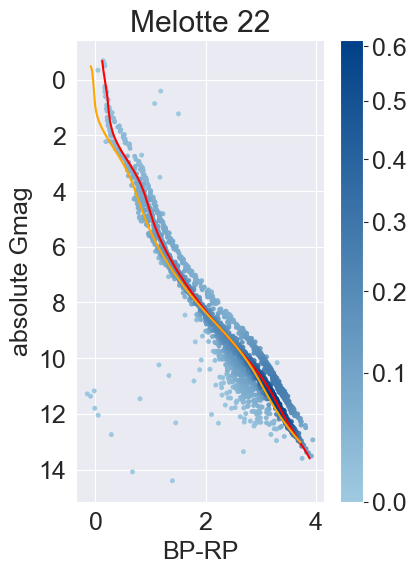

In [8]:
fig = CMD_density_design(OC.CMD, cluster_obj=OC)

# plt.plot(result_df["l_x"], result_df["l_y"], color="grey", label="5. perc")
plt.plot(result_df["m_x"], result_df["m_y"], color="red", label="new")
# plt.plot(result_df["u_x"], result_df["u_y"], color="grey", label="95. perc")
plt.plot(CMD1.cax, CMD1.abs_G, color="orange", label="old")

plt.show()

## 6. Calculate the difference between the curves

In [9]:
# Interpolate the second curve onto the x values of the first curve
y2_interp = np.interp(result_df["m_x"], CMD1.cax, CMD1.abs_G)

# Calculate the absolute difference between the two curves
# difference = np.abs(result_df["m_y"] - y2_interp)
euclidean_distances = np.sqrt((result_df["m_y"] - y2_interp) ** 2)

# Calculate the area between the curves using the trapezoidal rule
area_between_curves = simps(euclidean_distances, result_df["m_x"])

print("Area between curves:", area_between_curves)

Area between curves: 1.1641176307170609
